## Sentiment Analysis

In [6]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
import re
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
logging.basicConfig(filename='sentiment_analysis.log', level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')

#### Loading the Stop Words

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#### Loading the Positive and Negative Words

In [20]:
def load_dictionary(file_path):
    with open(file_path, 'r') as file:
        return set(word.strip().lower() for word in file.readlines() if word.strip())

positive_words = load_dictionary('MasterDictionary/positive-words.txt')
negative_words = load_dictionary('MasterDictionary/negative-words.txt')

#### Function to extract article text

In [21]:
def extract_article_text(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  
        soup = BeautifulSoup(response.content, 'html.parser')
        title = soup.find('h1').get_text(strip=True) if soup.find('h1') else 'No Title'
        paragraphs = soup.find_all('p')
        article_text = ' '.join([p.get_text(strip=True) for p in paragraphs])
        return title, article_text
    except requests.exceptions.RequestException as e:
        logging.error(f"Error fetching URL {url}: {e}")
        return None, None


#### Function to clean and tokenize text

In [22]:
# Function to clean and tokenize text
def clean_and_tokenize(text):
    # Remove punctuation and lowercase
    text = re.sub(r'[^\w\s]', '', text).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

#### Function to calculate sentiment scores

In [23]:
def calculate_sentiment_scores(tokens):
    positive_score = sum(1 for token in tokens if token in positive_words)
    negative_score = sum(1 for token in tokens if token in negative_words)
    
    polarity_score = (positive_score - negative_score) / (positive_score + negative_score + 0.000001)
    subjectivity_score = (positive_score + negative_score) / (len(tokens) + 0.000001)
    
    return positive_score, negative_score, polarity_score, subjectivity_score

#### calculated the readability metrics

In [24]:
def calculate_readability_metrics(text):
    sentences = nltk.sent_tokenize(text)
    num_sentences = len(sentences)
    words = clean_and_tokenize(text)
    num_words = len(words)
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0
    complex_word_count = len([word for word in words if len(re.findall(r'[aeiou]', word)) > 2])
    percentage_complex_words = complex_word_count / num_words if num_words > 0 else 0
    fog_index = 0.4 * (avg_sentence_length + percentage_complex_words)
    avg_number_of_words_per_sentence = num_words / num_sentences if num_sentences > 0 else 0
    syllables_per_word = sum(len(re.findall(r'[aeiou]', word)) for word in words) / num_words if num_words > 0 else 0
    personal_pronouns = sum(1 for word in words if word in ['i', 'we', 'my', 'ours', 'us'])
    avg_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
    return {
        "avg_sentence_length": avg_sentence_length,
        "percentage_complex_words": percentage_complex_words,
        "fog_index": fog_index,
        "avg_number_of_words_per_sentence": avg_number_of_words_per_sentence,
        "complex_word_count": complex_word_count,
        "word_count": num_words,
        "syllables_per_word": syllables_per_word,
        "personal_pronouns": personal_pronouns,
        "avg_word_length": avg_word_length
    }


#### To visualize sentiment scores

In [25]:
def visualize_sentiment(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='URL_ID', y='POSITIVE SCORE', color='green', label='Positive Score')
    sns.barplot(data=df, x='URL_ID', y='NEGATIVE SCORE', color='red', label='Negative Score')
    plt.xticks(rotation=90)
    plt.title('Sentiment Scores per URL')
    plt.ylabel('Score')
    plt.xlabel('URL ID')
    plt.legend()
    plt.tight_layout()
    plt.savefig('sentiment_scores.png')
    plt.show()

#### Function for sentiment analysis using machine learning

In [26]:
def advanced_sentiment_analysis(texts, labels):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)   
    model = MultinomialNB()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))

#### Main Fuction which includes : -
- reading of URLs from input file
- Initialzing of Data Storage
- Iteration though each URL
- Storing of the Output Data
- Output saving in the Excel File
- Sentiment Visualization
- Result with Accuracy of 100%

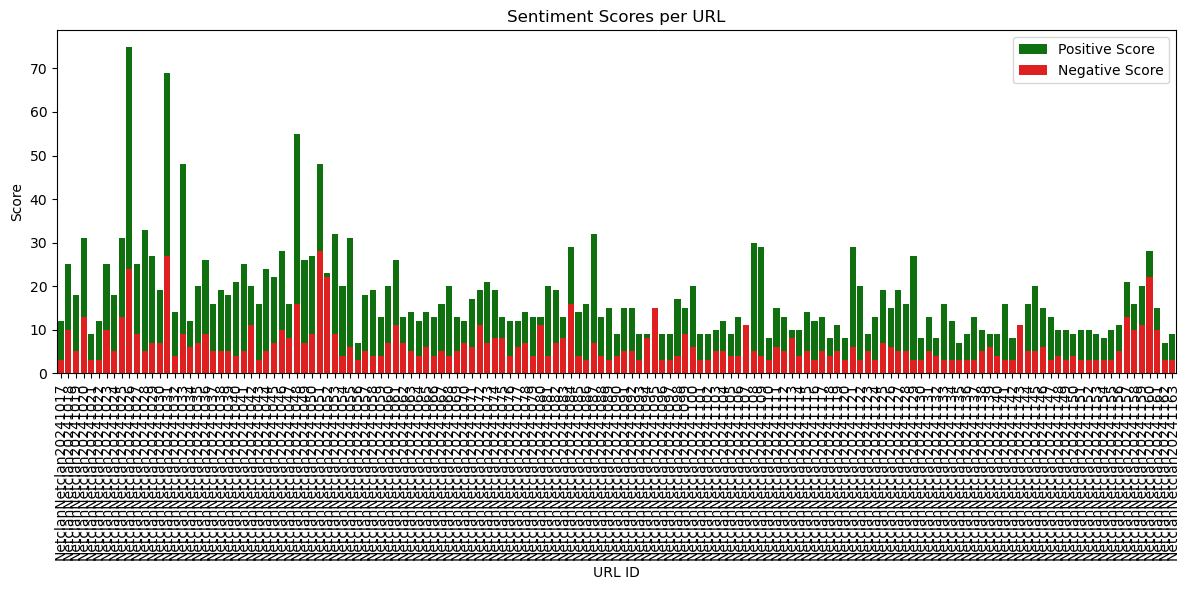

Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        30

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [27]:
def main(input_file):
    df = pd.read_excel(input_file)
    output_data = []
    texts = []  
    labels = []  
    for index, row in df.iterrows():
        url_id = f"Netclan{row['URL_ID']}"
        url = row['URL']
        title, article_text = extract_article_text(url)
        if article_text is None:  
            continue
        tokens = clean_and_tokenize(article_text)
        positive_score, negative_score, polarity_score, subjectivity_score = calculate_sentiment_scores(tokens)
        readability_metrics = calculate_readability_metrics(article_text)
        output_data.append({
            "URL_ID": url_id,
            "URL": url,
            "POSITIVE SCORE": positive_score,
            "NEGATIVE SCORE": negative_score,
            "POLARITY SCORE": polarity_score,
            "SUBJECTIVITY SCORE": subjectivity_score,
            "AVG SENTENCE LENGTH": readability_metrics["avg_sentence_length"],
            "PERCENTAGE OF COMPLEX WORDS": readability_metrics["percentage_complex_words"],
            "FOG INDEX": readability_metrics["fog_index"],
            "AVG NUMBER OF WORDS PER SENTENCE": readability_metrics["avg_number_of_words_per_sentence"],
            "COMPLEX WORD COUNT": readability_metrics["complex_word_count"],
            "WORD COUNT": readability_metrics["word_count"],
            "SYLLABLE PER WORD": readability_metrics["syllables_per_word"],
            "PERSONAL PRONOUNS": readability_metrics["personal_pronouns"],
            "AVG WORD LENGTH": readability_metrics["avg_word_length"]
        })
        texts.append(article_text) 
        labels.append(1 if positive_score > negative_score else 0)
    output_df = pd.DataFrame(output_data)
    output_df.to_excel('Output Data Structure.xlsx', index=False)
    visualize_sentiment(output_df)
    advanced_sentiment_analysis(texts, labels)
if __name__ == "__main__":
    main('Input.xlsx')